In [1]:
import warnings
warnings.filterwarnings("ignore")
import time,math
import numpy as np
from functions import cameraMatrix_cam1,cameraMatrix_cam2
from cv2 import circle,triangulatePoints,cvtColor,line,COLOR_GRAY2RGB,computeCorrespondEpilines,putText,FONT_HERSHEY_SIMPLEX,imwrite
from myLib import isCollinear,isEqual,swapElements,getSignal,getOrder,reshapeCoord,findNearestC,myProjectionPoints
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline
import os
from myLib import estimateFundMatrix_8norm,decomposeEssentialMat
import cv2
from itertools import permutations,combinations


#### Calibration

In [2]:
#dfCSV = np.genfromtxt('dataset_2.6m/working3/cam_all.csv', delimiter=',')
dfCSV = np.genfromtxt('camCalib.csv', delimiter=',')
verbose = False

In [3]:
def orderCenterCoord(centerCoord, prevCenterCoord, otherCamOrder = 0):
    centerX, centerY = reshapeCoord(centerCoord)
    # if it is the first image of the sequence
    if len(prevCenterCoord) == 0:  
        order,_ =  getOrder(centerX,centerY)  
        # if it is the second camera
        if otherCamOrder != 0:  
            # if the markers are wrong, swap the extremities
            signal, valid = getSignal(centerX[order[0]], centerX[order[2]],5)
            if signal != otherCamOrder and valid: order = swapElements(order, 0, 2)    
        else:        
            # get base for comparision (first camera only)        
            otherCamOrder,_ = getSignal(centerX[order[0]], centerX[order[2]])
        # sort centers        
        if np.linalg.norm(centerX[order[0]]-centerX[order[1]])>np.linalg.norm(centerX[order[2]]-centerX[order[1]]):
            sortedCenterCoord = np.array((centerCoord[order[0]], centerCoord[order[1]], centerCoord[order[2]]))
        else: sortedCenterCoord = np.array((centerCoord[order[2]], centerCoord[order[1]], centerCoord[order[0]]))
    else:
        # first reshape array of coordinates
        prevCenterX,prevCenterY = reshapeCoord(prevCenterCoord)
        # distance from marker A/B of previous img to center coordiantes of actual img
        distA = np.sqrt(np.power(np.subtract(prevCenterX[0], centerX), 2) + np.power(np.subtract(prevCenterY[0], centerY), 2))
        distB = np.sqrt(np.power(np.subtract(prevCenterX[1], centerX), 2) + np.power(np.subtract(prevCenterY[1], centerY), 2))
        # nearest marker from A is selected and removed as marker B candidate
        nearestA = np.argmin(distA)
        distBCopy = np.delete(distB, nearestA)
        # nearest marker from B is selected and removed as marker C candidate
        nearestBCopy = np.argmin(distBCopy)
        nearestB, = np.where(distB == distBCopy[nearestBCopy])
        distBCopy = np.delete(distBCopy, nearestBCopy)
        # get the missing marker position in array
        nearestC = findNearestC(nearestA, nearestB[0])
        # sort centers        
        sortedCenterCoord = [centerCoord[nearestA], centerCoord[nearestB[0]], centerCoord[nearestC]]
        # check if the ordering is ok
        centerX, centerY = reshapeCoord(sortedCenterCoord)
        prevOrder,axisPrev = getOrder(prevCenterX,prevCenterY)
        order,_ =  getOrder(centerX,centerY,baseAxis=True,axis=axisPrev)
        if (order[1] != 1) or (order[2] != prevOrder[2]):
            if prevOrder[0] == 2: order = swapElements(order,0,2) #if is decreasing, swap                
            sortedCenterCoord = np.array((sortedCenterCoord[order[0]], sortedCenterCoord[order[1]], sortedCenterCoord[order[2]]))
    return sortedCenterCoord, otherCamOrder



In [4]:
counter,i,lastTime = np.zeros(2,dtype=np.int32),0,np.zeros(2,dtype=np.int32)
missed,invalid,swap = np.zeros(2,dtype=np.int32),np.zeros(2,dtype=np.int32),np.zeros(2,dtype=np.int32)
lastImgNumber = np.zeros(2,dtype=np.int32)
certainty,intervals,timeIntervals = np.zeros(2,dtype=np.bool8),[[],[]],[[],[]]
dfOrig,tol = [[],[]],0.25

while i!=dfCSV.shape[0]:
    line = dfCSV[i]
    idx = int(line[8])
    # get points
    undCoord,time,imgNumber = line[0:6].reshape(-1,2),line[6],line[7]
    i+=1
    # add proccesing per occlusion here
    # if ts if not read corectly, discard
    if counter[idx]:
        if abs(time-lastTime[idx])>1e9: 
            if verbose: print('time missmatch')
            missed[idx]+=1
            invalid[idx]+=1
            continue
    # check if sequence is valid
    if imgNumber>lastImgNumber[idx]+1: invalid[idx] = imgNumber-lastImgNumber[idx]
    # order markers per proximity and check collinearity
    if isCollinear(*undCoord) and not isEqual(undCoord,5) and not np.any(undCoord<0):     
        if invalid[idx]>=10 or not counter[idx]: 
            if certainty[idx]:
                beg,end = intervals[idx][-1],counter[idx]-1
                timeIntervals[idx].append([dfOrig[idx][beg,6],dfOrig[idx][end,6]])
                if not idx: print('camera #'+str(idx)+' valid from '+str(round(dfOrig[idx][beg,6]/1e6,2))+'s to '+str(round(dfOrig[idx][end][6]/1e6,2))+'s')
            prev,certainty[idx] = [],False
            intervals[idx].append(counter[idx])
        else:
            if not (counter[idx]-1): prev = np.array(dfOrig[idx][0:6]).reshape(-1,2)
            else: prev = np.array(dfOrig[idx][-1,0:6]).reshape(-1,2)
        undCoord, _ = orderCenterCoord(undCoord,prev)
        undCoord = np.array(undCoord)
    else: 
        if verbose: print('not collinear or equal centroids')
        missed[idx]+=1
        invalid[idx]+=1
        continue
    # update loop variables
    lastTime[idx],lastImgNumber[idx],invalid[idx] = time,imgNumber,0
    if not counter[idx]: dfOrig[idx] = np.hstack((undCoord.reshape(6),time))
    else: dfOrig[idx] = np.vstack((dfOrig[idx],np.hstack((undCoord.reshape(6),time))))
    counter[idx]+=1
    # check if ABC is in order smaller to largest
    if not certainty[idx]:
        for [A,B,C] in undCoord.reshape([-1, 3, 2]):
            if np.linalg.norm(A-B)/np.linalg.norm(C-B)>(2-tol) and np.linalg.norm(A-B)>20:
                swap[idx] += 1
                if swap[idx]>2:    
                    swap[idx],certainty[idx] = 0,True
                    dfOrig[idx][intervals[idx][-1]:counter[idx],0:2],dfOrig[idx][intervals[idx][-1]:counter[idx],4:6] = np.copy(dfOrig[idx][intervals[idx][-1]:counter[idx],4:6]),np.copy(dfOrig[idx][intervals[idx][-1]:counter[idx],0:2])
            if np.linalg.norm(C-B)/np.linalg.norm(A-B)>(2-tol) and np.linalg.norm(C-B)>20:  certainty[idx] = True

# get last interval
for idx in range(2):
    if certainty[idx]:
        beg,end = intervals[idx][-1],counter[idx]-1
        timeIntervals[idx].append([dfOrig[idx][beg,6],dfOrig[idx][end,6]])    
        print('camera #'+str(idx)+' valid from '+str(round(dfOrig[idx][beg,6]/1e6,2))+'s to '+str(round(dfOrig[idx][end,6]/1e6,2))+'s')

## verbose
#os.system('rm pics/cam1/*')
#os.system('rm pics/cam2/*')
'''for idx in range(2):
    for j in range(0,dfOrig[idx].shape[0]):
        pts,name,img,k = dfOrig[idx][j,0:6].reshape(-1,2),int(dfOrig[idx][j,6]),np.ones((540,960,3))*255,0
        for k in range(0,3):
            pt = pts.reshape(-1,2)[k]
            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))
            circle(img,center,10,(255,0,0),5,shift=4)
            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) 
        imwrite('pics/cam'+str(idx+1)+'/'+str(name).zfill(20)+'.jpg',img)'''

# compute valid time intersection for interpolation
intersections = [[max(first[0], second[0]), min(first[1], second[1])]  
                    for first in timeIntervals[0] for second in timeIntervals[1]  
                    if max(first[0], second[0]) <= min(first[1], second[1])]

camera #0 valid from 0.03s to 1.4s
camera #0 valid from 2.67s to 6.6s
camera #0 valid from 7.32s to 9.42s
camera #0 valid from 10.05s to 13.17s
camera #0 valid from 13.94s to 16.77s
camera #0 valid from 17.39s to 17.67s
camera #0 valid from 18.19s to 20.84s
camera #0 valid from 21.27s to 21.42s
camera #0 valid from 21.87s to 24.59s
camera #0 valid from 25.07s to 26.62s
camera #0 valid from 26.91s to 29.19s
camera #0 valid from 30.14s to 32.71s
camera #0 valid from 33.01s to 39.14s
camera #0 valid from 41.48s to 55.95s
camera #0 valid from 56.63s to 63.33s
camera #0 valid from 63.7s to 74.22s
camera #0 valid from 74.57s to 78.87s
camera #0 valid from 79.25s to 79.72s
camera #0 valid from 80.15s to 80.84s
camera #0 valid from 81.12s to 83.22s


In [5]:
dfOrig[0].shape

(2717, 7)

In [6]:
step = 1/100
dfInterp = np.zeros((int(120/step),2*6+1))
dfInterp[:,-1] = np.linspace(0,120,int(120/step))

for [beg,end] in intersections:
    for idx in range(2):
        validIdx = [i for i in range(0,len(dfOrig[idx])) if beg<=dfOrig[idx][i,-1]<=end]
        coord,time = dfOrig[idx][validIdx,0:6],dfOrig[idx][validIdx,6]/1e6
        lowBound,highBound = math.ceil(time[0]/step),math.floor(time[-1]/step)
        print('interpolated #'+str(idx+1)+' from '+str(round(lowBound*step,2))+'s to '+str(round(highBound*step,2))+'s')
        tNew = np.linspace(lowBound,highBound,int((highBound-lowBound))+1,dtype=np.uint16)
        if time.shape[0]<=2: continue
        ff = CubicSpline(time,coord,axis=0)
        dfInterp[tNew,int(idx*6):int(idx*6+6)] = ff(tNew*step)

dfInterp = np.delete(dfInterp,np.unique([i for i in range(0,dfInterp.shape[0]) for idx in range(2) if not np.any(dfInterp[i][idx*6:idx*6+6])]),axis=0)
centroids1,centroids2 = dfInterp[:,0:6].reshape(-1,2),dfInterp[:,6:12].reshape(-1,2)

interpolated #1 from 3.7s to 6.59s
interpolated #2 from 3.68s to 6.57s
interpolated #1 from 7.33s to 8.17s
interpolated #2 from 7.33s to 8.17s
interpolated #1 from 8.75s to 9.42s
interpolated #2 from 8.75s to 9.39s
interpolated #1 from 10.05s to 13.17s
interpolated #2 from 10.05s to 13.14s
interpolated #1 from 14.82s to 15.24s
interpolated #2 from 14.8s to 15.24s
interpolated #1 from 16.3s to 16.76s
interpolated #2 from 16.27s to 16.74s
interpolated #1 from 17.4s to 17.66s
interpolated #2 from 17.45s to 17.64s
interpolated #1 from 18.2s to 18.41s
interpolated #2 from 18.2s to 18.41s
interpolated #1 from 20.55s to 20.84s
interpolated #2 from 20.52s to 20.81s
interpolated #1 from 21.27s to 21.41s
interpolated #2 from 21.27s to 21.39s
interpolated #1 from 21.87s to 24.59s
interpolated #2 from 21.87s to 24.56s
interpolated #1 from 25.07s to 26.61s
interpolated #2 from 25.07s to 26.59s
interpolated #1 from 26.92s to 27.08s
interpolated #2 from 26.92s to 27.09s
interpolated #1 from 27.47s to

In [7]:
dfInterp.shape

(5395, 13)

In [8]:
# get fundamental and essential matrices
F,_ = estimateFundMatrix_8norm(np.array(centroids1),np.array(centroids2))
E = np.matmul(cameraMatrix_cam2.T, np.matmul(F, cameraMatrix_cam1))
print("\nEssenc. Mat.\n", E.round(4))
# decompose to rotation and translation between cameras
R, t = decomposeEssentialMat(E, cameraMatrix_cam1, cameraMatrix_cam2, np.array(centroids1), np.array(centroids2))
if np.any(np.isnan(R)): print('no valid rotation matrix')
else:
    print("\nRot. Mat.\n", R.round(4))
    print("\nTrans. Mat.\n", t.round(4))

Fund. Mat.
 [[ 0.     -0.     -0.0015]
 [-0.     -0.      0.0083]
 [-0.001  -0.0018  1.    ]]
avg x'Fx=0: 0.4605485063759077
max x'Fx=0: 2.0977320302792117

Essenc. Mat.
 [[ 0.1894 -3.4146 -2.722 ]
 [-3.5602 -0.3965  3.7913]
 [-2.2237 -3.5494 -0.054 ]]

Rot. Mat.
 [[-0.1513 -0.6044  0.7822]
 [ 0.5341  0.6159  0.5792]
 [-0.8318  0.5054  0.2296]]

Trans. Mat.
 [[-0.6229 -0.438   0.6482]]


Scale between real world and triang. point cloud is:  398.86
L_AC >> mean = 15.6606cm, std. dev = 0.2659cm, rms = 0.2688cm
L_AB >> mean = 5.5821cm, std. dev = 0.0953cm, rms = 0.1258cm
L_BC >> mean = 10.0869cm, std. dev = 0.1979cm, rms = 0.2279cm
Images distant more than 1% from the real value = 2947/5395


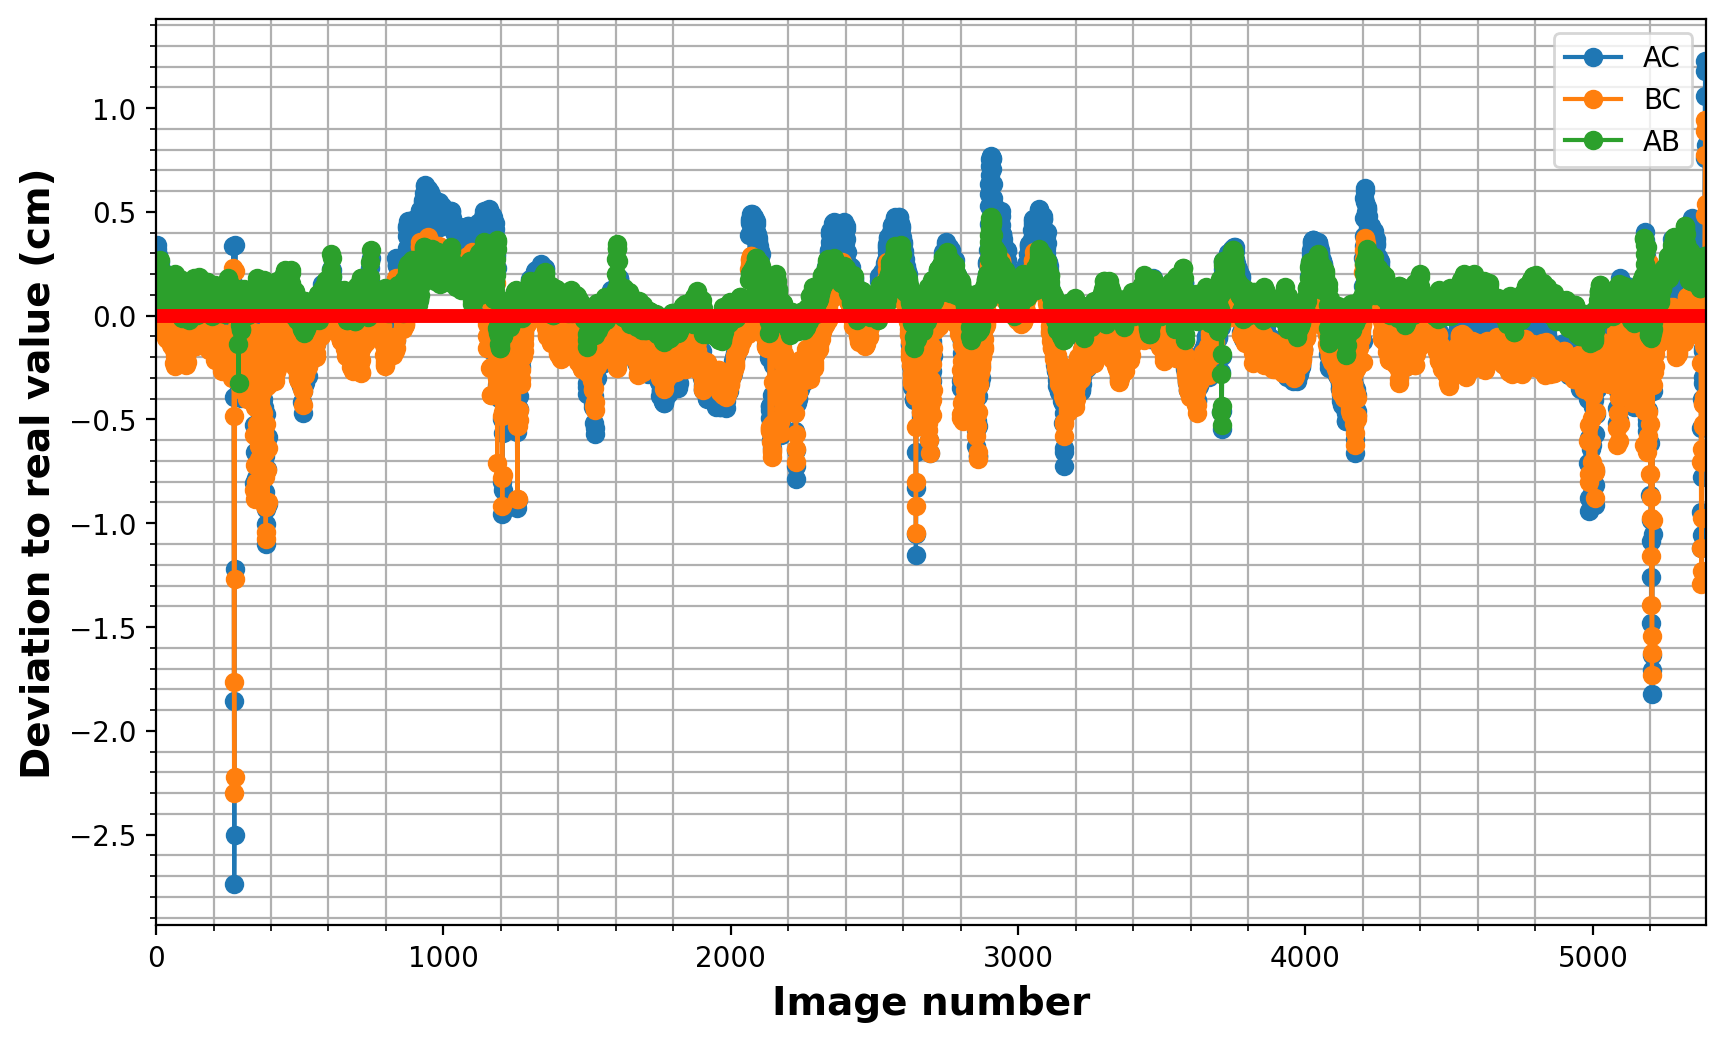

In [9]:
P1,P2 = np.hstack((cameraMatrix_cam1, [[0.], [0.], [0.]])),np.matmul(cameraMatrix_cam2, np.hstack((R, t.T)))
projPt1,projPt2 = myProjectionPoints(np.array(centroids1)),myProjectionPoints(np.array(centroids2))
points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
points3d = (points4d[:3, :]/points4d[3, :]).T
if points3d[0, 2] < 0: points3d = -points3d
tot,L_real_AC,L_real_AB,L_real_BC,L_AC_vec,L_BC_vec,L_AB_vec,k,false_idx = 0,15.7,5.5,10.2,[],[],[],0,[]
# compute sdt deviation and plot beautiful stuff
for [A, B, C] in points3d.reshape([-1, 3, 3]):
    L_rec_AC,L_rec_BC,L_rec_AB = np.linalg.norm(A-C),np.linalg.norm(B-C),np.linalg.norm(A-B)
    if L_rec_AB>L_rec_BC: continue
    tot = tot + L_real_AC/L_rec_AC + L_real_BC/L_rec_BC + L_real_AB/L_rec_AB
    k = k + 3
    lamb = tot/k
    L_AC_vec.append(L_rec_AC)
    L_BC_vec.append(L_rec_BC)
    L_AB_vec.append(L_rec_AB)
print('Scale between real world and triang. point cloud is: ', lamb.round(2))
print('L_AC >> mean = ' + str((np.mean(L_AC_vec)*lamb).round(4)) +
    "cm, std. dev = " + str((np.std(L_AC_vec)*lamb).round(4)) +
    "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AC_vec)*lamb-L_real_AC)))).round(4)) + "cm")
print('L_AB >> mean = ' + str((np.mean(L_AB_vec)*lamb).round(4)) +
    "cm, std. dev = " + str((np.std(L_AB_vec)*lamb).round(4)) +
    "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AB_vec)*lamb-L_real_AB)))).round(4)) + "cm")
print('L_BC >> mean = ' + str((np.mean(L_BC_vec)*lamb).round(4)) +
    "cm, std. dev = " + str((np.std(L_BC_vec)*lamb).round(4)) +
    "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_BC_vec)*lamb-L_real_BC)))).round(4)) + "cm")
fig = plt.figure(figsize=(10, 6), dpi=200)
L_AC_vec_plot,L_BC_vec_plot,L_AB_vec_plot = np.array(L_AC_vec)*lamb - L_real_AC,np.array(L_BC_vec)*lamb - L_real_BC,np.array(L_AB_vec)*lamb - L_real_AB
plt.plot(L_AC_vec_plot, '-o', label="AC")
plt.plot(L_BC_vec_plot, '-o', label="BC")
plt.plot(L_AB_vec_plot, '-o', label="AB")
plt.axhline(y=0.0, color='r', linestyle='-',linewidth=5)
plt.grid()
#plt.axvline(x=853, c='r', linestyle='--', label="image 960")
plt.xlabel("Image number",fontsize=14, fontweight='bold')
plt.ylabel("Deviation to real value (cm)",fontsize=14,fontweight='bold')
plt.legend()
ax = fig.axes
ax[0].minorticks_on()
plt.grid(which='both')
plt.xlim(0,len(L_AC_vec)-1)
points3d_new,i,k= points3d*lamb,0,0
for [A, B, C] in points3d_new.reshape([-1, 3, 3]):
    L_reconst = np.sqrt(np.sum((A-C)**2, axis=0))
    valid = abs(L_real_AC-L_reconst)/L_real_AC < 0.01
    if not valid: 
        i = i + 1
        false_idx.extend((k,k+1,k+2))
    k+=3

print("Images distant more than 1% from the real value = " + str(i)+'/'+str(int(points3d.shape[0]/3)))
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.draw()
plt.show()
centroids1,centroids2=np.delete(centroids1,false_idx,axis=0),np.delete(centroids2,false_idx,axis=0)

Fund. Mat.
 [[ 0.     -0.     -0.0015]
 [-0.     -0.      0.0085]
 [-0.001  -0.0018  1.    ]]
avg x'Fx=0: 0.4350140063377538
max x'Fx=0: 2.1234763032123443

Essenc. Mat.
 [[ 0.1985 -3.5052 -2.7702]
 [-3.6579 -0.4047  3.8593]
 [-2.2624 -3.6134 -0.0546]]

Rot. Mat.
 [[-0.1569 -0.6008  0.7838]
 [ 0.5296  0.6187  0.5802]
 [-0.8336  0.5062  0.2212]]

Trans. Mat.
 [[-0.6209 -0.4364  0.6512]]
Scale between real world and triang. point cloud is:  400.1
L_AC >> mean = 15.6591cm, std. dev = 0.0771cm, rms = 0.0873cm
L_AB >> mean = 5.5761cm, std. dev = 0.0563cm, rms = 0.0947cm
L_BC >> mean = 10.0905cm, std. dev = 0.0713cm, rms = 0.1307cm
Images distant more than 1% from the real value = 105/2448


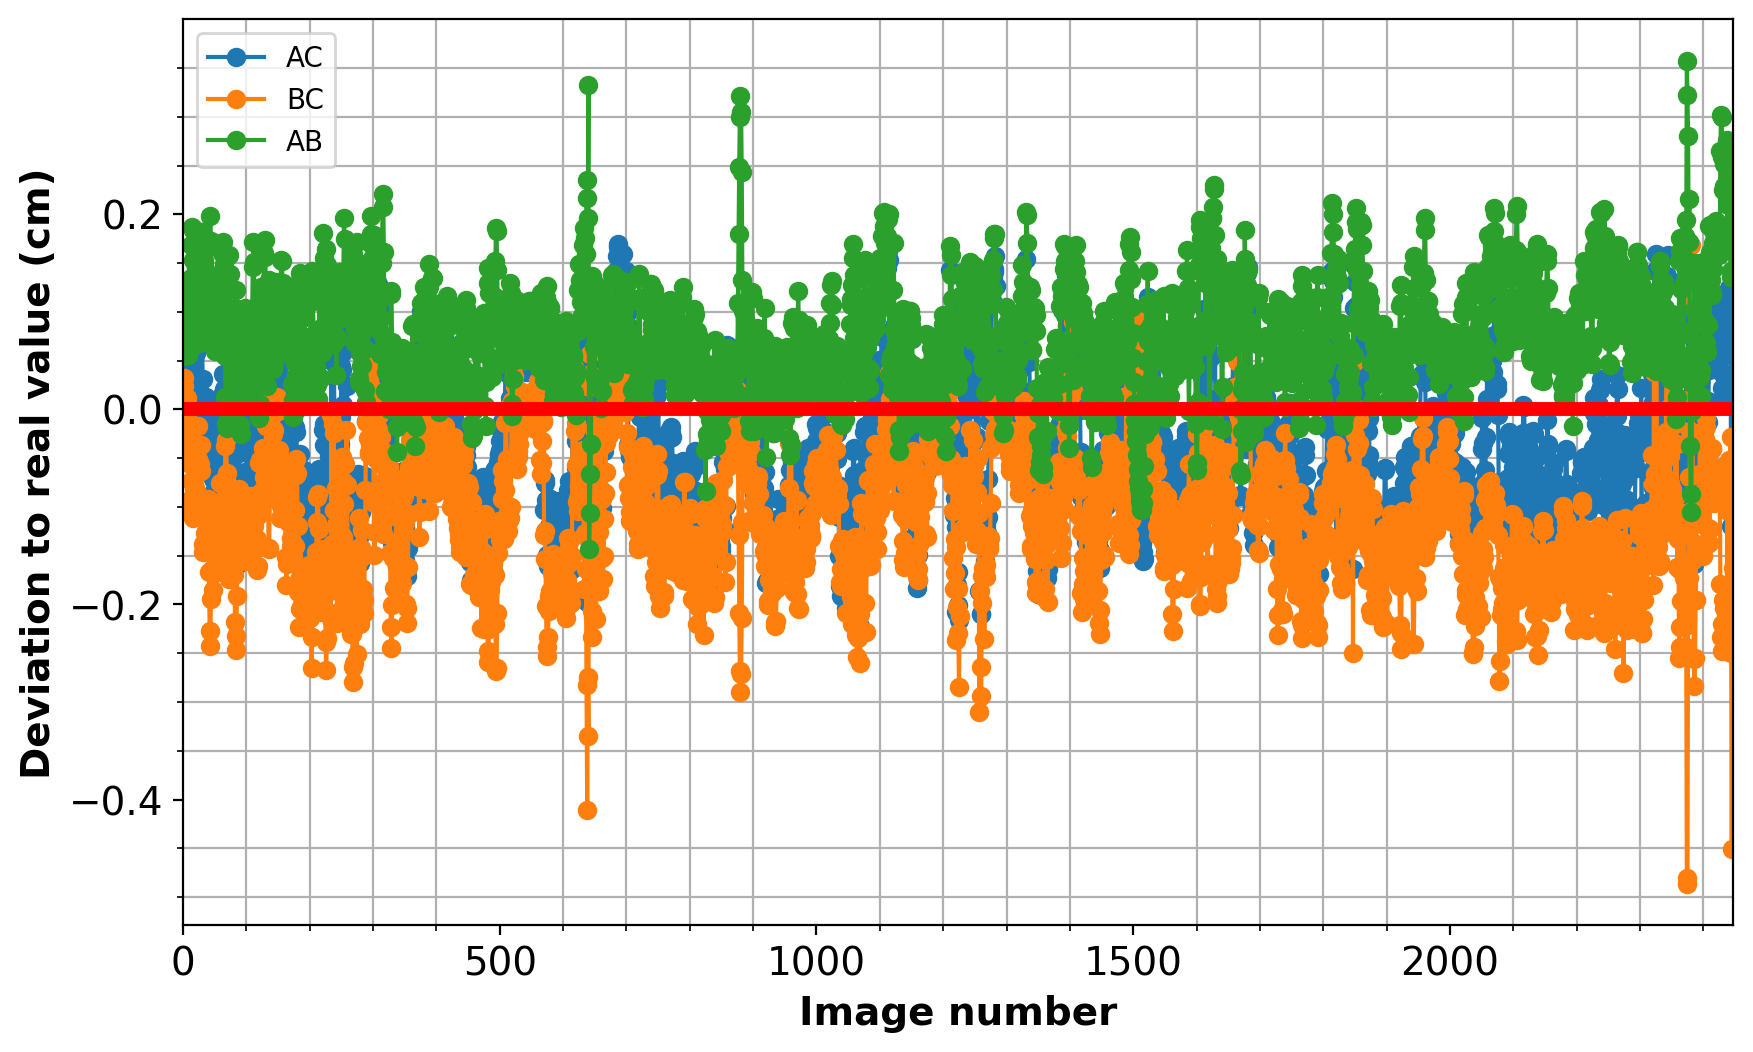

In [10]:
# get fundamental and essential matrices
F,_ = estimateFundMatrix_8norm(np.array(centroids1),np.array(centroids2))
E = np.matmul(cameraMatrix_cam2.T, np.matmul(F, cameraMatrix_cam1))
print("\nEssenc. Mat.\n", E.round(4))
# decompose to rotation and translation between cameras
R, t = decomposeEssentialMat(E, cameraMatrix_cam1, cameraMatrix_cam2, np.array(centroids1), np.array(centroids2))
if np.any(np.isnan(R)): print('no valid rotation matrix')
else:
    print("\nRot. Mat.\n", R.round(4))
    print("\nTrans. Mat.\n", t.round(4))
P1,P2 = np.hstack((cameraMatrix_cam1, [[0.], [0.], [0.]])),np.matmul(cameraMatrix_cam2, np.hstack((R, t.T)))
projPt1,projPt2 = myProjectionPoints(np.array(centroids1)),myProjectionPoints(np.array(centroids2))
points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
points3d = (points4d[:3, :]/points4d[3, :]).T
if points3d[0, 2] < 0: points3d = -points3d
tot,L_AC_vec,L_BC_vec,L_AB_vec,k = 0,[],[],[],0
# compute sdt deviation and plot beautiful stuff
for [A, B, C] in points3d.reshape([-1, 3, 3]):
    L_rec_AC,L_rec_BC,L_rec_AB = np.linalg.norm(A-C),np.linalg.norm(B-C),np.linalg.norm(A-B)
    #if L_rec_AB<L_rec_BC: L_rec_AB,L_rec_BC=L_rec_BC,L_rec_AB
    tot = tot + L_real_AC/L_rec_AC + L_real_BC/L_rec_BC + L_real_AB/L_rec_AB
    k = k + 3
    lamb = tot/k
    L_AC_vec.append(L_rec_AC)
    L_BC_vec.append(L_rec_BC)
    L_AB_vec.append(L_rec_AB)
print('Scale between real world and triang. point cloud is: ', lamb.round(2))
print('L_AC >> mean = ' + str((np.mean(L_AC_vec)*lamb).round(4)) +
    "cm, std. dev = " + str((np.std(L_AC_vec)*lamb).round(4)) +
    "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AC_vec)*lamb-L_real_AC)))).round(4)) + "cm")
print('L_AB >> mean = ' + str((np.mean(L_AB_vec)*lamb).round(4)) +
    "cm, std. dev = " + str((np.std(L_AB_vec)*lamb).round(4)) +
    "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_AB_vec)*lamb-L_real_AB)))).round(4)) + "cm")
print('L_BC >> mean = ' + str((np.mean(L_BC_vec)*lamb).round(4)) +
    "cm, std. dev = " + str((np.std(L_BC_vec)*lamb).round(4)) +
    "cm, rms = " + str((np.sqrt(np.mean(np.square(np.array(L_BC_vec)*lamb-L_real_BC)))).round(4)) + "cm")
fig = plt.figure(figsize=(10, 6), dpi=200)
L_AC_vec_plot,L_BC_vec_plot,L_AB_vec_plot = np.array(L_AC_vec)*lamb - L_real_AC,np.array(L_BC_vec)*lamb - L_real_BC,np.array(L_AB_vec)*lamb - L_real_AB
plt.plot(L_AC_vec_plot, '-o', label="AC")
plt.plot(L_BC_vec_plot, '-o', label="BC")
plt.plot(L_AB_vec_plot, '-o', label="AB")
plt.axhline(y=0.0, color='r', linestyle='-',linewidth=5)
plt.grid()
#plt.axvline(x=853, c='r', linestyle='--', label="image 960")
plt.xlabel("Image number",fontsize=14, fontweight='bold')
plt.ylabel("Deviation to real value (cm)",fontsize=14,fontweight='bold')
plt.legend()
ax = fig.axes
ax[0].minorticks_on()
plt.grid(which='both')
plt.xlim(0,len(L_AC_vec)-1)
points3d_new,i= points3d*lamb,0
for [A, B, C] in points3d_new.reshape([-1, 3, 3]):
    L_reconst = np.sqrt(np.sum((A-C)**2, axis=0))
    valid = abs(L_real_AC-L_reconst)/L_real_AC < 0.01
    if not valid: i = i + 1
print("Images distant more than 1% from the real value = " + str(i)+'/'+str(int(points3d.shape[0]/3)))
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.draw()
plt.show()

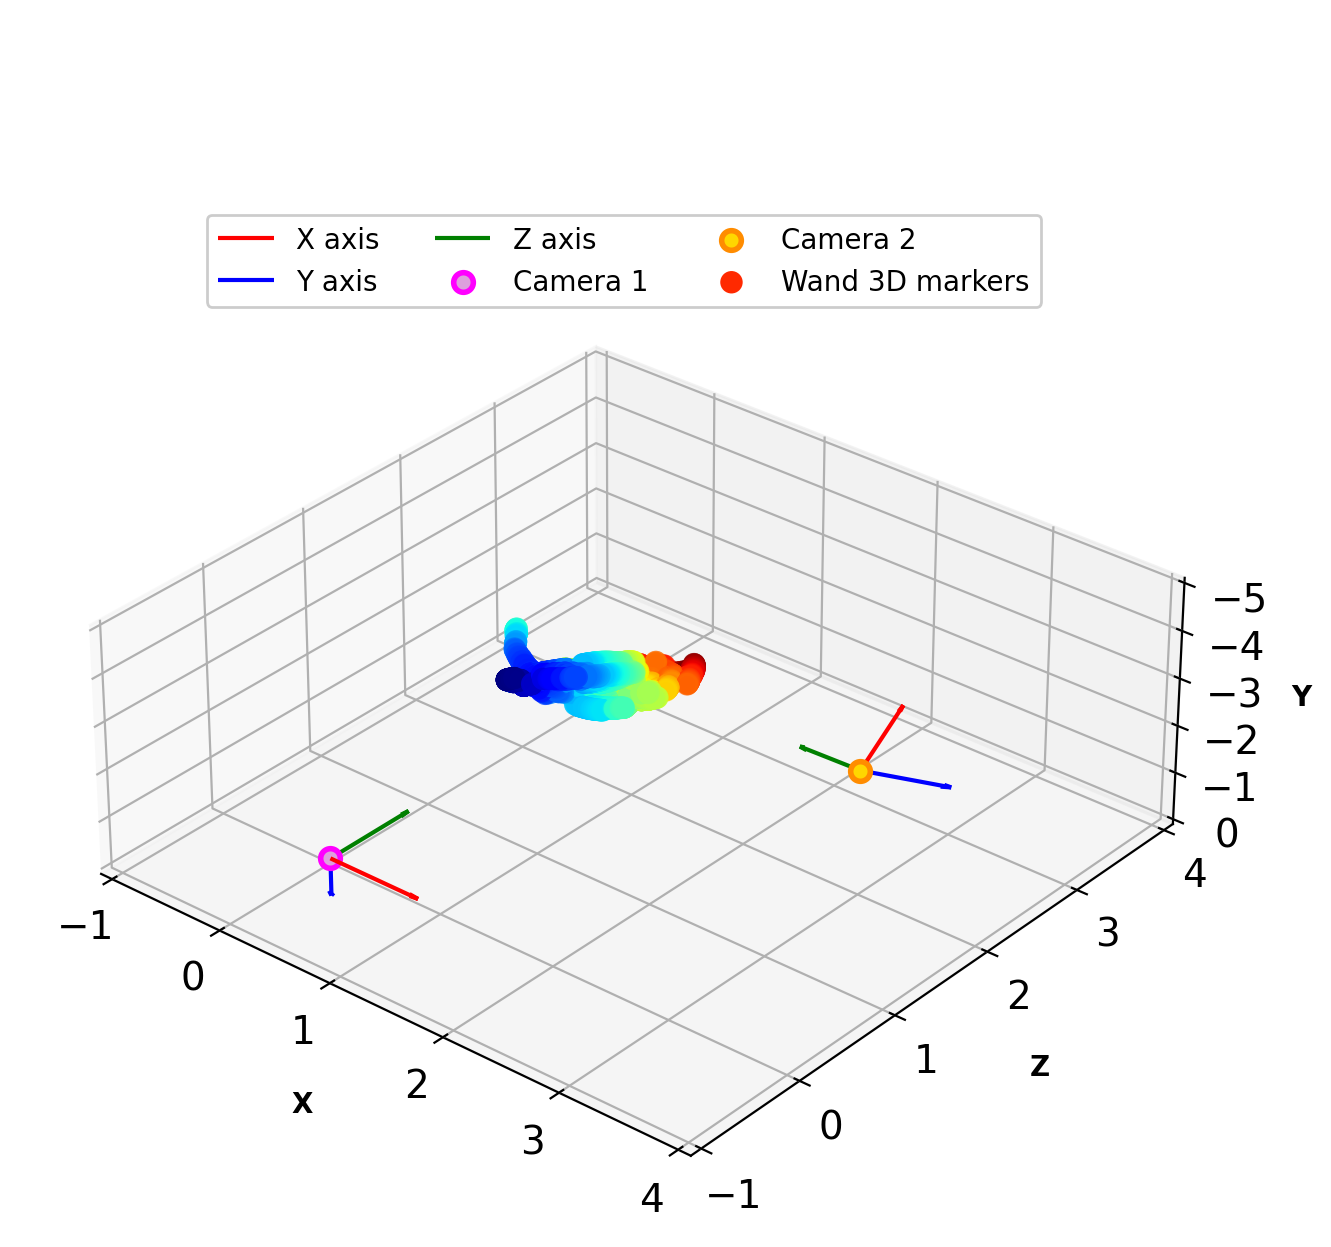

In [11]:
# plot 3d map
fig = plt.figure(figsize=(8, 8),dpi=200)
ax = plt.axes(projection='3d')
ax.set_xlim(-1, 4)
ax.set_zlim(-5, 0)
ax.set_ylim(-1, 4)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_xlabel('X', fontweight='bold',labelpad=15)
ax.set_ylabel('Z', fontweight='bold',labelpad=15)
ax.set_zlabel('Y', fontweight='bold',labelpad=5)
scale = 0.8
x,y,z = np.array([scale, 0, 0]), np.array([0, scale, 0]),np.array([0, 0, scale])
# rotate second camera to the same plane
t_new = np.matmul(-t, R)*lamb/100
#theta = np.arctan2(t_aux[0][1],t_aux[0][0])
#Rz = np.array([[np.cos(-theta),np.sin(-theta),0], [np.sin(-theta), np.cos(-theta),0], [0,0,1]])
#x,y,z = np.matmul(Rz, x),np.matmul(Rz, y),np.matmul(Rz, z)
ax.quiver(0, 0, 0, x[0], x[2], x[1], arrow_length_ratio=0.1, edgecolors="r", label = 'X axis')
ax.quiver(0, 0, 0, y[0], y[2], y[1], arrow_length_ratio=0.1, edgecolors="b", label = 'Y axis')
ax.quiver(0, 0, 0, z[0], z[2], z[1], arrow_length_ratio=0.1, edgecolors="g", label = 'Z axis')
ax.scatter(0, 0, 0, s=50, edgecolor="fuchsia", facecolor="plum", linewidth=2, label = 'Camera 1')
x,y,z = np.array([scale, 0, 0]), np.array([0, scale, 0]),np.array([0, 0, scale])
x,y,z = np.matmul(R.T, x),np.matmul(R.T, y),np.matmul(R.T, z)
#x,y,z = np.matmul(Rz, x),np.matmul(Rz, y),np.matmul(Rz, z)
#t_new,points3d_new = np.matmul(Rz,t_aux.T).T,np.matmul(Rz,points3d.T).T
points3d_new = points3d
ax.quiver(t_new[0][0], t_new[0][2], t_new[0][1], x[0], x[2], x[1], arrow_length_ratio=0.1, edgecolors="r")
ax.quiver(t_new[0][0], t_new[0][2], t_new[0][1], y[0], y[2], y[1], arrow_length_ratio=0.1, edgecolors="b")
ax.quiver(t_new[0][0], t_new[0][2], t_new[0][1], z[0], z[2], z[1], arrow_length_ratio=0.1, edgecolors="g")
ax.scatter(t_new[0][0], t_new[0][2], t_new[0][1], s=50, edgecolor="darkorange", facecolor="gold", linewidth=2,  label = 'Camera 2')
cmhot = plt.get_cmap("jet")
ax.view_init(elev=30, azim=-50) 
ax.scatter(points3d_new[:, 0]*lamb/100, points3d_new[:, 2]*lamb/100, points3d_new[:, 1]*lamb/100, c=points3d_new[:, 2], cmap=cmhot,s = 50,label='Wand 3D markers')
plt.gca().invert_zaxis()
plt.legend(ncol=3,loc ='center',edgecolor='silver', bbox_to_anchor=(0.5, 0.8)) 
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 1., .5, 1.]))
plt.draw()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


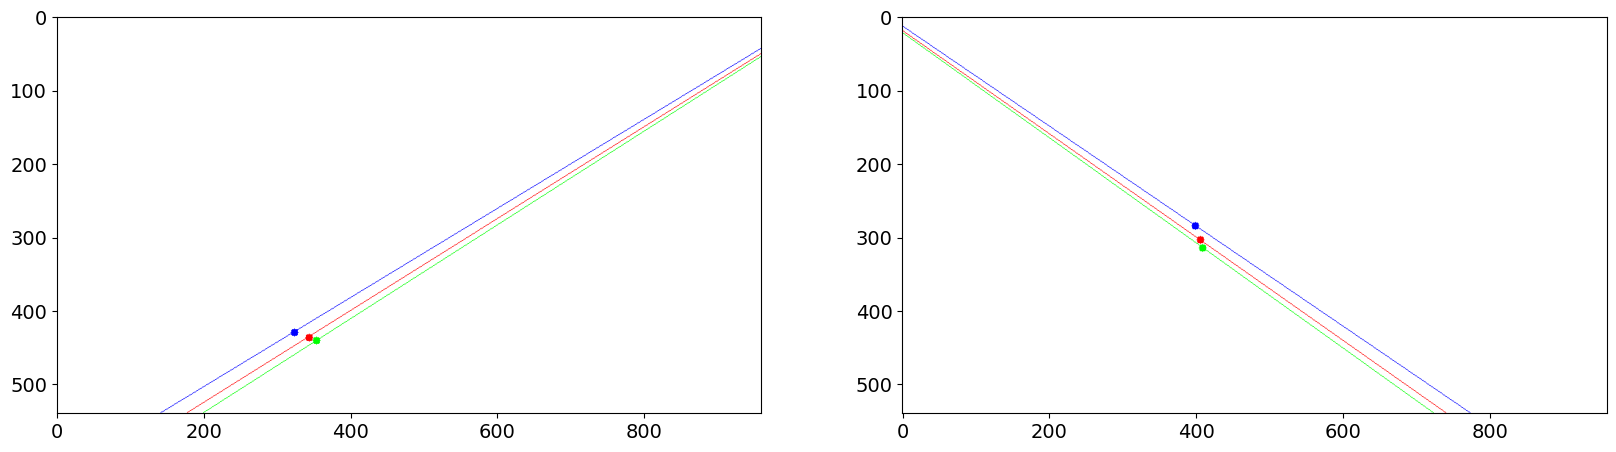

In [12]:
img1,img2,k = np.ones((540,960))*255,np.ones((540,960))*255,500
pts1,pts2 = np.int32(centroids1[k:k+3].reshape(-1,2)),np.int32(centroids2[k:k+3].reshape(-1,2))
from cv2 import line

def drawlines(img1,img2,lines,pts1,pts2):
    r,c = img1.shape
    img1 = cvtColor(img1.astype('float32'),COLOR_GRAY2RGB)
    img2 = cvtColor(img2.astype('float32'),COLOR_GRAY2RGB)
    listColors = [(0,0,255),(0,255,0),(255,0,0)]
    i = 0
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = listColors[i]
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = line(img1, (x0,y0), (x1,y1), color,1)
        img1 = circle(img1,tuple(pt1),5,color,-1)
        img2 = circle(img2,tuple(pt2),5,color,-1)
        i+=1
    return img1,img2

lines1 = computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
lines2 = computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.figure(figsize=(20, 16),dpi=100)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()


#### Ground plane

In [13]:
def isEqual4(pt,tol=5):
    A,B,C,D = pt[0],pt[1],pt[2],pt[3]
    AB,AC,BC = np.linalg.norm(A-B),np.linalg.norm(A-C),np.linalg.norm(C-B)
    AD,BD,CD = np.linalg.norm(A-D),np.linalg.norm(B-D),np.linalg.norm(C-D)
    return min(AB,AC,BC,AD,BD,CD)<tol

def getEpilineCoef(pts,F):
    [a,b,c]=np.matmul(F,np.hstack((pts,1))) #ax+by+c=0
    return [a,b,c]/(np.sqrt(pow(a,2)+pow(b,2)))

def getDistance2Line(line,pts):
    a,b,c = line
    out = []
    for [x,y] in pts:
       out.append(abs(a*x+b*y+c)/np.sqrt(np.sqrt(pow(a,2)+pow(b,2))))
    return np.array(out)    

def drawlines(img1,img2,lines,pts1,pts2):
    r,c = img1.shape
    img1 = cvtColor(img1.astype('float32'),COLOR_GRAY2RGB)
    img2 = cvtColor(img2.astype('float32'),COLOR_GRAY2RGB)
    listColors = [(0,255,255),(0,255,0),(255,0,255),(255,0,255)]
    i = 0
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = listColors[i]
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = line(img1, (x0,y0), (x1,y1), color,2)
        img1 = circle(img1,tuple(pt1),10,color,-1)
        img2 = circle(img2,tuple(pt2),10,color,-1)
        i+=1
    return img1,img2

def findPlane(A,C,D):
    x1,y1,z1 = A
    x2,y2,z2 = C
    x3,y3,z3 = D
    a1,b1,c1 = x2-x1,y2-y1,z2-z1
    a2,b2,c2 = x3-x1,y3-y1,z3-z1
    a,b,c = b1*c2-b2*c1,a2*c1-a1*c2,a1*b2-b1*a2
    d=(-a*x1-b*y1-c*z1)
    return np.array([a,b,c,d])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


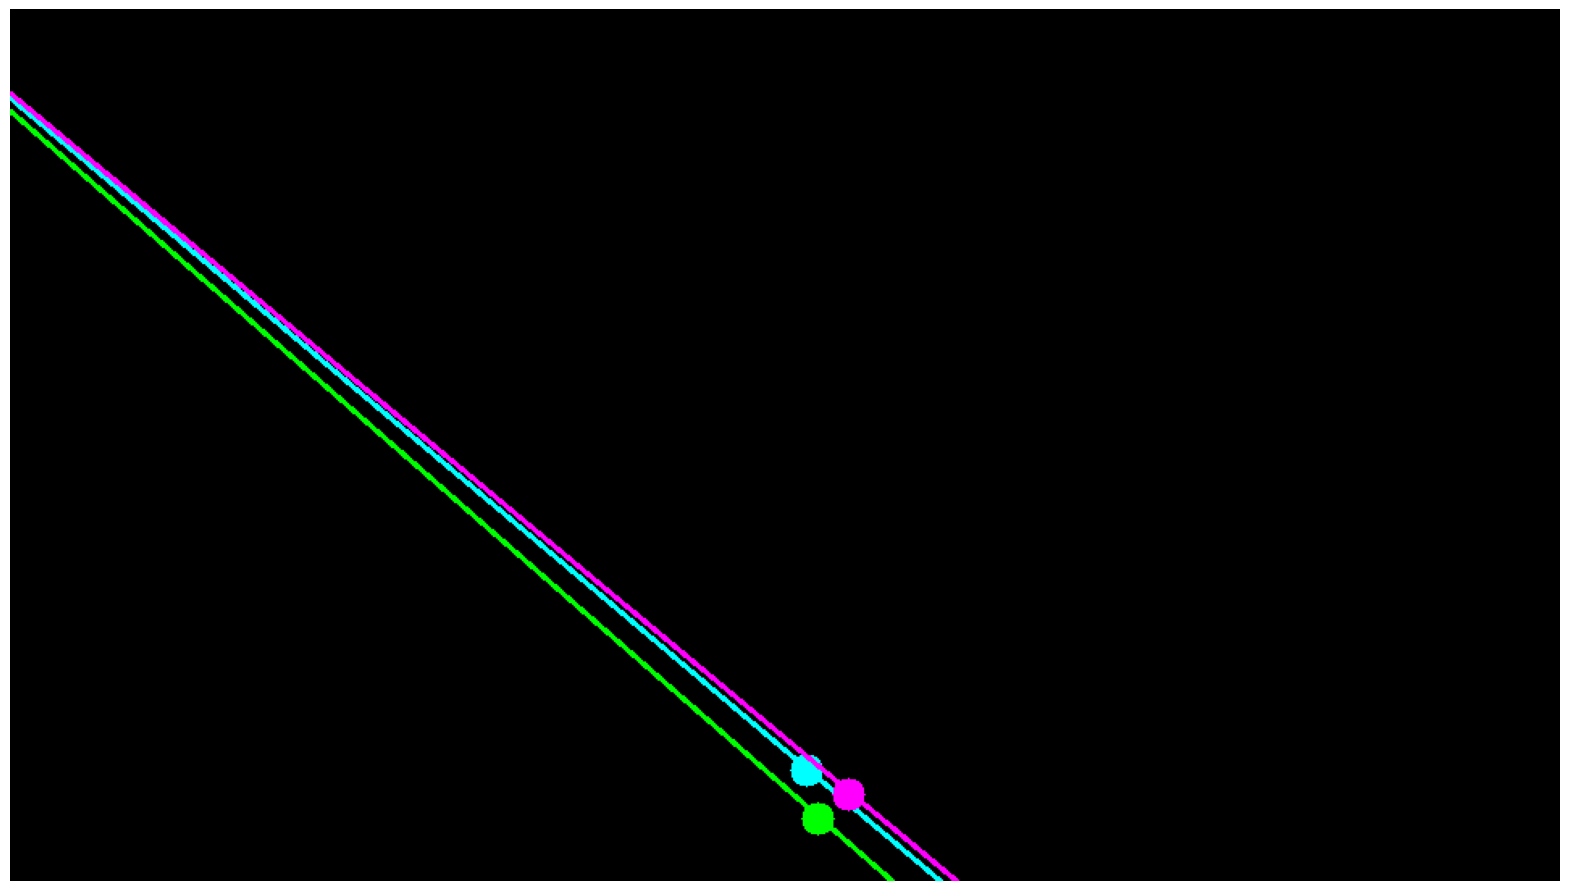

In [14]:
dfCSV = np.genfromtxt('camGround.csv', delimiter=',')
counter,i,lastTime = np.zeros(2,dtype=np.int32),0,np.zeros(2,dtype=np.int32)

while i!=dfCSV.shape[0]:
    line = dfCSV[i]
    idx = int(line[8])
    # get points
    undCoord,time,imgNumber = line[0:6].reshape(-1,2),line[6],line[7]
    # save points
    if not counter[idx]: dfOrig[idx] = np.hstack((undCoord.reshape(6),time))
    # update variables
    i+=1
    counter[idx]+=1
    # do I have enough points?
    if np.all(counter>0): break

pts1,pts2,orderSecondFrame = np.int32(dfOrig[0][0:6].reshape(-1,2)),np.int32(dfOrig[1][0:6].reshape(-1,2)),[]
# choose order per epiline
for i in range(3):
    epiline,dist,k = getEpilineCoef(pts1[i],F),[],0
    orderSecondFrame.append(np.argmin(getDistance2Line(epiline,pts2)))
pts2 = np.copy(pts2[orderSecondFrame])
# verbose
from cv2 import line
img1,img2 = np.zeros((540,960)),np.zeros((540,960))
lines1 = computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,_ = drawlines(img1,img2,lines1,pts1,pts2)
lines2 = computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,_ = drawlines(img2,img1,lines2,pts2,pts1)
plt.figure(figsize=(20, 16),dpi=100)
plt.imshow(img5) 
plt.axis('off') 
#plt.savefig('epi1.png', bbox_inches='tight')
plt.imshow(img3)
plt.axis('off') 
#plt.savefig('epi2.png', bbox_inches='tight')

plt.show()

In [15]:
# tiangulate
P1,P2 = np.hstack((cameraMatrix_cam1, [[0.], [0.], [0.]])),np.matmul(cameraMatrix_cam2, np.hstack((R, t.T)))
projPt1,projPt2 = myProjectionPoints(np.array(pts1)),myProjectionPoints(np.array(pts2))
points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
points3d = (points4d[:3, :]/points4d[3, :]).T
if points3d[0, 2] < 0: points3d = -points3d
plane = findPlane(points3d[0]*lamb/100,points3d[1]*lamb/100,points3d[2]*lamb/100)
if np.any(plane[0:3]<0): plane = findPlane(points3d[0]*lamb/100,points3d[2]*lamb/100,points3d[1]*lamb/100)

In [16]:
[a,b,c,d]=plane
v,k=np.array([a,b,c]),np.array([0,1,0])
cosPhi = np.dot(v,k)/(np.linalg.norm(v)*np.linalg.norm(k))
[u1,u2,u3] = np.cross(v,k)/np.linalg.norm(np.cross(v,k))
sinPhi = np.sqrt(1-pow(cosPhi,2))
R_plane = np.array([
        [cosPhi+u1*u1*(1-cosPhi),u1*u2*(1-cosPhi),u2*sinPhi],
        [u1*u2*(1-cosPhi),cosPhi+u2*u2*(1-cosPhi),-u1*sinPhi],
        [-u2*sinPhi,u1*sinPhi,cosPhi]])
[A,B,C] = np.matmul(np.array([a,b,c]),R_plane.T)
newPlane = np.array([A,B,C])

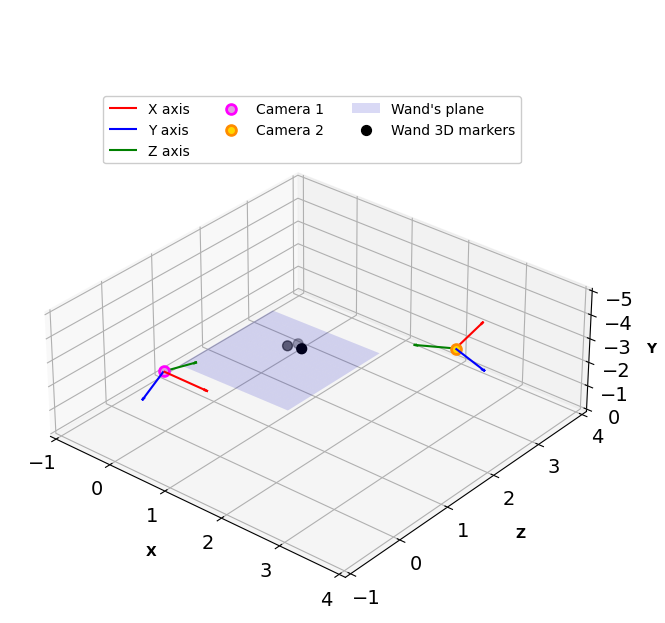

In [17]:
# tiangulate
points3dNew = points3d*lamb/100
# configure 3d map
fig = plt.figure(figsize=(8, 8),dpi=100)
ax = plt.axes(projection='3d')
ax.set_xlim(-1, 4)
ax.set_zlim(-5, 0)
ax.set_ylim(-1, 4)
ax.set_xlabel('X', fontweight='bold',labelpad=15)
ax.set_ylabel('Z', fontweight='bold',labelpad=15)
ax.set_zlabel('Y', fontweight='bold',labelpad=5)
# plot first camera
scale = 0.8
cam1Pts = np.array([[0,d/b,0],
                    [scale, 0, 0],
                    [0, scale, 0],
                    [0, 0, scale]])
cam1PtsNew = np.matmul(R_plane,cam1Pts.T).T
[cam1Root,x,y,z]=cam1PtsNew
zDisplacement = cam1PtsNew[0,2]
cam1Root+=[0,0,-zDisplacement]
x,y,z=x/np.linalg.norm(x)*scale,y/np.linalg.norm(y)*scale,z/np.linalg.norm(z)*scale
ax.quiver(cam1Root[0],cam1Root[2],cam1Root[1],x[0],x[2],x[1], arrow_length_ratio=0.1, edgecolors="r", label = 'X axis')
ax.quiver(cam1Root[0],cam1Root[2],cam1Root[1],y[0],y[2],y[1], arrow_length_ratio=0.1, edgecolors="b", label = 'Y axis')
ax.quiver(cam1Root[0],cam1Root[2],cam1Root[1],z[0],z[2],z[1], arrow_length_ratio=0.1, edgecolors="g", label = 'Z axis')
ax.scatter(cam1Root[0],cam1Root[2],cam1Root[1], s=50, edgecolor="fuchsia", facecolor="plum", linewidth=2, label = 'Camera 1')
# plot second camera
x,y,z = np.array([scale, 0, 0]), np.array([0, scale, 0]),np.array([0, 0, scale])
x,y,z = np.matmul(R.T, x),np.matmul(R.T, y),np.matmul(R.T, z)
t_aux = np.matmul(-t, R)[0]*lamb/100+[0,d/b,0]
cam2Pts = np.array([t_aux.T,x,y,z])
cam2PtsNew = np.matmul(R_plane,cam2Pts.T).T
[cam2Root,x,y,z]=cam2PtsNew
cam2Root+=[0,0,-zDisplacement]
x,y,z=x/np.linalg.norm(x)*scale,y/np.linalg.norm(y)*scale,z/np.linalg.norm(z)*scale
ax.quiver(cam2Root[0],cam2Root[2],cam2Root[1],x[0],x[2],x[1], arrow_length_ratio=0.1, edgecolors="r")
ax.quiver(cam2Root[0],cam2Root[2],cam2Root[1],y[0],y[2],y[1], arrow_length_ratio=0.1, edgecolors="b")
ax.quiver(cam2Root[0],cam2Root[2],cam2Root[1],z[0],z[2],z[1], arrow_length_ratio=0.1, edgecolors="g")
ax.scatter(cam2Root[0],cam2Root[2],cam2Root[1], s=50, edgecolor="darkorange", facecolor="gold", linewidth=2,  label = 'Camera 2')
# new plane
x,z = np.linspace(-1,1,30),np.linspace(3,5,10)
X,Z = np.meshgrid(x,z)
Y=(-newPlane[0]*X -newPlane[2]*Z)/newPlane[1]
surf = ax.plot_surface(X,Z-zDisplacement,Y,color='b',alpha=.15,label="Wand's plane")
surf._facecolors2d = surf._facecolor3d
surf._edgecolors2d = surf._edgecolor3d
points3dNew = np.matmul(R_plane,points3dNew.T+np.array([[0],[d/b],[0]])).T
ax.scatter(points3dNew[:, 0], points3dNew[:, 2]-zDisplacement, points3dNew[:, 1], color='black',s = 50,label='Wand 3D markers')
# axis setup
ax.view_init(elev=30, azim=-50) 
plt.legend(ncol=3,loc ='center',edgecolor='silver', bbox_to_anchor=(0.5, 0.8)) 
plt.gca().invert_zaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 1., .5, 1.]))
#plt.savefig('withRot_2.png', bbox_inches='tight')
plt.draw()
plt.show()

#### Test

In [18]:
def getDistance2Line(lines,pts):
    pts,out,lines = np.copy(pts).reshape(-1,2),[],np.copy(lines).reshape(-1,3)
    for [a,b,c] in lines:
        for [x,y] in pts: out.append(abs(a*x+b*y+c)/np.sqrt(np.sqrt(pow(a,2)+pow(b,2))))
    return np.array(out)<5,np.array(out) 

def drawlines(img1,img2,lines,pts1,pts2):    
    r,c = img1.shape
    img1 = cvtColor(img1.astype('float32'),COLOR_GRAY2RGB)
    img2 = cvtColor(img2.astype('float32'),COLOR_GRAY2RGB)
    listColors = [(0,0,255),(0,255,0),(255,0,0),(255,0,255)]
    i = 0
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = listColors[i]
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = circle(img1,tuple(pt1),5,color,-1)
        putText(img1,str(i),tuple(pt1-20),FONT_HERSHEY_SIMPLEX,0.5,color,2) 
        img2 = circle(img2,tuple(pt2),5,color,-1)
        putText(img2,str(i),tuple(pt2-20),FONT_HERSHEY_SIMPLEX,0.5,color,2) 
        i+=1
    return img1,img2


In [19]:
def getOrderPerEpiline(coord1,coord2,nMarkers,verbose = 0):
    pts1,pts2,orderSecondFrame = np.copy(coord1).reshape(-1,2),np.copy(coord2).reshape(-1,2),np.ones(nMarkers,dtype=np.int8)*-1
    epilines = np.zeros((nMarkers,3))
    choosenIdx,allDists = [],[]
    # choose order per epiline
    for i in range(nMarkers):
        epilines[i] = getEpilineCoef(pts1[i],F)        
    allPermuationsOf4 = np.array(list(permutations(list(range(0,4)))))
    for idx2 in allPermuationsOf4:
        newPts2,dist = pts2[idx2],0
        for k in range(nMarkers): 
            _,aux= getDistance2Line(epilines[k],newPts2[k])
            dist+=aux
        allDists.append(dist)
    minDist = min(allDists)
    choosenIdx = allPermuationsOf4[np.where(allDists<=minDist+1)[0]]
    if len(choosenIdx)>1:
        allCombinationsOf2 = np.array(list(combinations(list(range(0,len(choosenIdx))),2)))
        mask = np.ones(nMarkers,dtype=np.bool)
        for idx in allCombinationsOf2:
            nowMask = np.equal(choosenIdx[idx[0]],choosenIdx[idx[1]])
            mask*=nowMask
        mask = np.invert(mask)
        idxAmbiguous1,idxAmbiguous2 = np.where(mask)[0],choosenIdx[0][mask]
        collinearPts1,collinearPts2 = pts1[idxAmbiguous1],pts2[idxAmbiguous2]
        if np.all(np.diff(np.sort(collinearPts2[:,0]))>2) and np.all(np.diff(np.sort(collinearPts1[:,0]))>2):
            order1,order2 = np.argsort(collinearPts1[:,0]),np.argsort(collinearPts2[:,0])
            idx1 = np.hstack((collinearPts1,idxAmbiguous1.reshape(idxAmbiguous1.shape[0],-1)))[order1,-1].T
            idx2 = np.hstack((collinearPts2,idxAmbiguous2.reshape(idxAmbiguous2.shape[0],-1)))[order2,-1].T
        else:
            order1,order2 = np.argsort(collinearPts1[:,1]),np.argsort(collinearPts2[:,1])
            idx1 = np.hstack((collinearPts1,idxAmbiguous1.reshape(idxAmbiguous1.shape[0],-1)))[order1,-1].T
            idx2 = np.hstack((collinearPts2,idxAmbiguous2.reshape(idxAmbiguous2.shape[0],-1)))[order2,-1].T
        orderSecondFrame = choosenIdx[0]
        orderSecondFrame[idx1.astype(int)] = idx2.astype(int)
    else: orderSecondFrame = choosenIdx[0]
    
    ## verbose
    if verbose:
        pts2 = np.copy(pts2[orderSecondFrame])
        img1,img2 = np.ones((720,960))*255,np.ones((720,960))*255
        lines1 = computeCorrespondEpilines(np.int32(pts2).reshape(-1,1,2), 2,F)
        lines1 = lines1.reshape(-1,3)
        img5,_ = drawlines(img1,img2,lines1,np.int32(pts1),np.int32(pts2))
        lines2 = computeCorrespondEpilines(np.int32(pts1).reshape(-1,1,2), 1,F)
        lines2 = lines2.reshape(-1,3)
        img3,_ = drawlines(img2,img1,lines2,np.int32(pts2),np.int32(pts1))
        plt.figure(figsize=(20, 16),dpi=100)
        plt.subplot(121),plt.imshow(img5)
        plt.subplot(122),plt.imshow(img3)
        plt.show()
    return orderSecondFrame

#import time
#start=time.time()
#print(getOrderPerEpiline(dfOrig[0][0,0:8],dfOrig[1][0,0:8],4,0))
#print(time.time()-start)

In [20]:
def getTheClosest(coordNow, prev):
    centerCoord,prevCenterCoord = np.copy(coordNow).reshape(-1,2),np.copy(prev).reshape(-1,2)
    newOrder,nMarkers = np.ones(centerCoord.shape[0],dtype=np.int8)*-1,centerCoord.shape[0]
    for i in range(nMarkers):
        if newOrder[i] == -1:
            pt = prevCenterCoord[i]        
            distNow = np.linalg.norm(centerCoord-pt,axis=1)
            retNow = distNow < 5
            if np.sum(retNow) == 1: newOrder[i] = np.argmin(distNow)
            else:              
                allPermuationsOf4,allDists = np.array(list(permutations(list(range(0,4))))),[]
                for idx in allPermuationsOf4:
                    newPts,dist = centerCoord[idx],0
                    for k in range(nMarkers): 
                        aux= np.linalg.norm(prevCenterCoord[k]-newPts[k])
                        dist+=aux
                    allDists.append(dist)
                minDist = np.argmin(allDists)
                choosenIdx = allPermuationsOf4[minDist]
                return choosenIdx
    return newOrder

import time

In [21]:
def myInterpolate(coord,ts,step):
    if not len(ts): return [],[]
    lowBound,highBound = math.ceil(ts[0]/step),math.floor(ts[-1]/step)
    tNew = np.linspace(lowBound,highBound,int((highBound-lowBound))+1,dtype=np.uint16)
    ff = CubicSpline(ts,coord,axis=0)
    return ff(tNew*step),tNew

In [22]:
dfCSV = np.genfromtxt('G:/Meu Drive/UFCG/Mestrado/MoCap/CSV datasets/7Jun/camTest_50cmSquare_only4Blobs.csv', delimiter=',')
counter,i,lastTime = np.zeros(2,dtype=np.int32),0,np.zeros(2,dtype=np.int32)
missed,invalid,swap = np.zeros(2,dtype=np.int32),np.zeros(2,dtype=np.int32),np.zeros(2,dtype=np.int32)
lastImgNumber = np.zeros(2,dtype=np.int32)
intervals,lastTnew = [[],[]],[[],[]]
dfOrig,nPrevious,warmUp = [[],[]],3,10 # warm up> n previous
verbose,needsOrder = True,True
points3d = []

step = 1/100
dfInterp = np.zeros((int(60/step),2*8+1))
dfInterp[:,-1] = np.linspace(0,60,int(60/step))
timeArray = []

while i!=dfCSV.shape[0]:
    start = time.time()
    line = dfCSV[i]
    idx = int(line[10])
    # get points
    undCoord,timeNow,imgNumber = line[0:8].reshape(-1,2),line[8],line[9]
    i+=1
    # if ts if not read corectly, discard
    if counter[idx]:
        if abs(timeNow-lastTime[idx])>1e9: 
            if verbose: print('time missmatch')
            missed[idx]+=1
            invalid[idx]+=1
            continue
    # check if sequence is valid
    if imgNumber>lastImgNumber[idx]+1: invalid[idx] = imgNumber-lastImgNumber[idx]
    # order markers per proximity and check collinearity
    if not isEqual(undCoord,5) and not np.any(undCoord<0):     
        if invalid[idx]>=10 or not counter[idx]: 
            # discard image if resert is done and no ordering has been set
            if verbose: print('reseting at camera', idx,', counter',counter[idx],',',timeNow/1e6,'s')
            prev,needsOrder = [],True
            intervals[idx].append(counter[idx])
        else:
            if not (counter[idx]-1): prev = np.array(dfOrig[idx][0:8]).reshape(-1,2)
            else: prev = np.array(dfOrig[idx][-1,0:8]).reshape(-1,2)
            newOrder = getTheClosest(undCoord.reshape(-1,2),prev.reshape(-1,2))
            undCoord = np.copy(undCoord[newOrder])
    else: 
        if verbose: print('not collinear or equal centroids')
        missed[idx]+=1
        invalid[idx]+=1
        continue
    # update loop variables
    lastTime[idx],lastImgNumber[idx],invalid[idx] = timeNow,imgNumber,0    
    if not counter[idx]: dfOrig[idx] = np.hstack((undCoord.reshape(8),timeNow))
    else: dfOrig[idx] = np.vstack((dfOrig[idx],np.hstack((undCoord.reshape(8),timeNow))))
    counter[idx]+=1
    # interpolate
    if np.all(counter):
        if needsOrder:
            # get is there are enough points at the valid interval
            if np.all(counter-[intervals[0][-1],intervals[1][-1]]>=nPrevious):
                if verbose: print('in storage',counter-[intervals[0][-1],intervals[1][-1]])
                # see if there are intersection between arrays
                ts1,ts2 = dfOrig[0][intervals[0][-1]:counter[0],8]/1e6,dfOrig[1][intervals[1][-1]:counter[1],8]/1e6
                validIdx1 = [k for k in range(0,len(ts1)) if max(ts1[0], ts2[0])-0.01<=ts1[k]<=min(ts1[-1], ts2[-1])+0.01]
                validIdx2 = [k for k in range(0,len(ts2)) if max(ts1[0], ts2[0])-0.01<=ts2[k]<=min(ts1[-1], ts2[-1])+0.01]
                # if there is intersection, get order
                if len(validIdx1) and len(validIdx2):
                    ts1,ts2 = np.copy(ts1[validIdx1]),np.copy(ts2[validIdx2])
                    if ts1.shape[0]<2 or ts2.shape[0]<2: continue
                    coord1,coord2 = dfOrig[0][intervals[0][-1]:counter[0],0:8],dfOrig[1][intervals[1][-1]:counter[1],0:8]
                    coord1,coord2 = np.copy(coord1[validIdx1]),np.copy(coord2[validIdx2])
                    # get interpolated data
                    interp1,tNew1 = myInterpolate(coord1,ts1,step)
                    interp2,tNew2 = myInterpolate(coord2,ts2,step)
                    if not len(interp1) or not len(interp2): continue
                    # get common idx
                    interpolateIdx1,interpolateIdx2 = np.argmax(np.in1d(tNew1, tNew2)),np.argmax(np.in1d(tNew2, tNew1))
                    orderSecondFrame = getOrderPerEpiline(interp1[interpolateIdx1],interp2[interpolateIdx2],4,0)
                    # get interval to rearrange
                    idxInvalid = np.argmin(counter-[intervals[0][-1],intervals[1][-1]])
                    beg = [k for k in range(intervals[1][-1],counter[1]) if dfOrig[idxInvalid][intervals[idxInvalid][-1],8]-0.01<=dfOrig[1][k,8]][0]
                    if verbose:print('rearranging interval',[beg,counter[1]-1], 'to', orderSecondFrame)
                    # flip blobs
                    for k in range(beg,counter[1]):
                        dfOrig[1][k,0:8] = np.copy(dfOrig[1][k,0:8].reshape(-1,2)[orderSecondFrame].reshape(-8))
                    needsOrder=False
        if np.all(counter-[intervals[0][-1],intervals[1][-1]]>=warmUp): 
            coord,ts = dfOrig[idx][(counter[idx]-warmUp):counter[idx],0:8],dfOrig[idx][(counter[idx]-warmUp):counter[idx],8]/1e6
            if not len(ts): continue
            lowBound,highBound = math.ceil(ts[0]/step),math.floor(ts[-1]/step)
            if lastTnew[idx]:
                if lowBound<lastTnew[idx]: lowBound = lastTnew[idx]+1
            tNew = np.linspace(lowBound,highBound,int((highBound-lowBound))+1,dtype=np.uint16)
            ff = CubicSpline(ts,coord,axis=0)
            dfInterp[tNew,int(idx*8):int(idx*8+8)] = ff(tNew*step)
            lastTnew[idx],otherIdx = tNew[-1],int(not idx)
            for k in tNew:
                if np.all(dfInterp[k,int(otherIdx*8):int(otherIdx*8+8)]):
                    centroids1,centroids2 = dfInterp[k,0:8].reshape(-1,2),dfInterp[k,8:16].reshape(-1,2)
                    projPt1,projPt2 = myProjectionPoints(np.array(centroids1)),myProjectionPoints(np.array(centroids2))
                    points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
                    myPoints3d = (points4d[:3, :]/points4d[3, :]).T
                    if myPoints3d[0, 2] < 0: myPoints3d = -myPoints3d
                    if not len(points3d): points3d = np.copy(myPoints3d)
                    else: points3d = np.vstack((points3d,myPoints3d))
    timeArray.append(time.time()-start)

dfInterp = np.delete(dfInterp,np.unique([i for i in range(0,dfInterp.shape[0]) for idx in range(2) if not np.any(dfInterp[i][idx*8:idx*8+8])]),axis=0)
print()
print('tMin:',round(np.min(timeArray),5),'s')
print('tMean:',round(np.mean(timeArray),5),'s')
print('tMax:',round(np.max(timeArray),5),'s')
print('tStdDev:',round(np.std(timeArray),5),'s')
#centroids1,centroids2 = dfInterp[:,0:8].reshape(-1,2),dfInterp[:,8:16].reshape(-1,2)
'''for idx in range(2):
    beg,end = intervals[idx][-1],counter[idx]-1
    timeIntervals[idx].append([dfOrig[idx][beg,8],dfOrig[idx][end,8]])    
    print('Final: camera #'+str(idx)+' valid from '+str(round(dfOrig[idx][beg,8]/1e6,2))+'s to '+str(round(dfOrig[idx][end,8]/1e6,2))+'s')

intersections = [[max(first[0], second[0]), min(first[1], second[1])]  
                    for first in timeIntervals[0] for second in timeIntervals[1]  
                    if max(first[0], second[0]) <= min(first[1], second[1])]'''
## verbose
'''os.system('del pics\cam1\*jpg')
os.system('del pics\cam2\*jpg')
for idx in range(2):
    for j in range(0,dfOrig[idx].shape[0]):
        pts,name,img,k = dfOrig[idx][j,0:8].reshape(-1,2),int(dfOrig[idx][j,8]),np.ones((720,960,3))*255,0
        for k in range(0,4):
            pt = pts.reshape(-1,2)[k]
            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))
            circle(img,center,10,(255,0,0),5,shift=4)
            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) 
        imwrite('pics/cam'+str(idx+1)+'/'+str(name).zfill(20)+'.jpg',img)'''

reseting at camera 0 , counter 0 , 0.02502 s
reseting at camera 1 , counter 0 , 0.025015 s
in storage [7 3]
rearranging interval [0, 2] to [2 3 1 0]
reseting at camera 1 , counter 5 , 0.624812 s
reseting at camera 1 , counter 7 , 0.924687 s
reseting at camera 1 , counter 9 , 1.4245 s
in storage [68  3]
rearranging interval [9, 11] to [2 3 1 0]
reseting at camera 1 , counter 12 , 2.04927 s
in storage [81  3]
in storage [82  3]
in storage [82  4]
in storage [82  5]
rearranging interval [12, 16] to [2 3 1 0]
reseting at camera 1 , counter 764 , 22.891563 s
reseting at camera 1 , counter 765 , 49.031896 s
reseting at camera 1 , counter 766 , 51.830857 s
in storage [2072    3]
rearranging interval [766, 768] to [2 3 1 0]
reseting at camera 1 , counter 799 , 55.179591 s
in storage [2205    3]
rearranging interval [799, 801] to [2 3 1 0]
reseting at camera 1 , counter 820 , 57.42878 s
in storage [2298    3]
rearranging interval [820, 822] to [2 3 1 0]
reseting at camera 1 , counter 838 , 58.9

"os.system('del pics\\cam1\\*jpg')\nos.system('del pics\\cam2\\*jpg')\nfor idx in range(2):\n    for j in range(0,dfOrig[idx].shape[0]):\n        pts,name,img,k = dfOrig[idx][j,0:8].reshape(-1,2),int(dfOrig[idx][j,8]),np.ones((720,960,3))*255,0\n        for k in range(0,4):\n            pt = pts.reshape(-1,2)[k]\n            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))\n            circle(img,center,10,(255,0,0),5,shift=4)\n            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) \n        imwrite('pics/cam'+str(idx+1)+'/'+str(name).zfill(20)+'.jpg',img)"

In [23]:
'''step = 1/100
dfInterp = np.zeros((int(60/step),2*8+1))
dfInterp[:,-1] = np.linspace(0,60,int(60/step))

for [beg,end] in intersections:
    for idx in range(2):
        validIdx = [i for i in range(0,len(dfOrig[idx])) if beg<=dfOrig[idx][i,-1]<=end]
        coord,time = dfOrig[idx][validIdx,0:8],dfOrig[idx][validIdx,8]/1e6
        if not len(time): continue
        lowBound,highBound = math.ceil(time[0]/step),math.floor(time[-1]/step)
        print('interpolated #'+str(idx+1)+' from '+str(round(lowBound*step,2))+'s to '+str(round(highBound*step,2))+'s')
        tNew = np.linspace(lowBound,highBound,int((highBound-lowBound))+1,dtype=np.uint16)
        if time.shape[0]<=2: continue
        ff = CubicSpline(time,coord,axis=0)
        dfInterp[tNew,int(idx*8):int(idx*8+8)] = ff(tNew*step)

dfInterp = np.delete(dfInterp,np.unique([i for i in range(0,dfInterp.shape[0]) for idx in range(2) if not np.any(dfInterp[i][idx*8:idx*8+8])]),axis=0)
'''
'''timeArray = []
import time
for i in range(0,dfInterp.shape[0]):
    start = time.time()
    orderSecondFrame = getOrderPerEpiline(dfInterp[i,0:8],dfInterp[i,8:16],4,0)
    timeArray.append(time.time()-start)
    if not np.all(np.equal(orderSecondFrame,[2,3,1,0])):
        print(orderSecondFrame,dfInterp[i,-1],i)
    dfInterp[i,8:16] = np.copy(dfInterp[i,8:16].reshape(-1,2)[orderSecondFrame].reshape(-8))
    

print(np.min(timeArray),np.mean(timeArray),np.max(timeArray))
centroids1,centroids2 = dfInterp[:,0:8].reshape(-1,2),dfInterp[:,8:16].reshape(-1,2)'''

'''os.system('del pics\cam1\*jpg')
os.system('del pics\cam2\*jpg')
for idx in range(2):
    for j in range(0,dfInterp.shape[0]):
        pts,name,img,k = dfInterp[j,int(idx*8):int(idx*8+8)].reshape(-1,2),j,np.ones((720,960,3))*255,0
        for k in range(0,4):
            pt = pts.reshape(-1,2)[k]
            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))
            circle(img,center,10,(255,0,0),5,shift=4)
            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) 
        imwrite('pics/cam'+str(idx+1)+'/'+str(name).zfill(20)+'.jpg',img)'''


"os.system('del pics\\cam1\\*jpg')\nos.system('del pics\\cam2\\*jpg')\nfor idx in range(2):\n    for j in range(0,dfInterp.shape[0]):\n        pts,name,img,k = dfInterp[j,int(idx*8):int(idx*8+8)].reshape(-1,2),j,np.ones((720,960,3))*255,0\n        for k in range(0,4):\n            pt = pts.reshape(-1,2)[k]\n            center = (int(np.round(pt[0]*16)),int(np.round(pt[1]*16)))\n            circle(img,center,10,(255,0,0),5,shift=4)\n            putText(img,str(k),(int(center[0]/16)-25, int(center[1]/16)-25),FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2) \n        imwrite('pics/cam'+str(idx+1)+'/'+str(name).zfill(20)+'.jpg',img)"

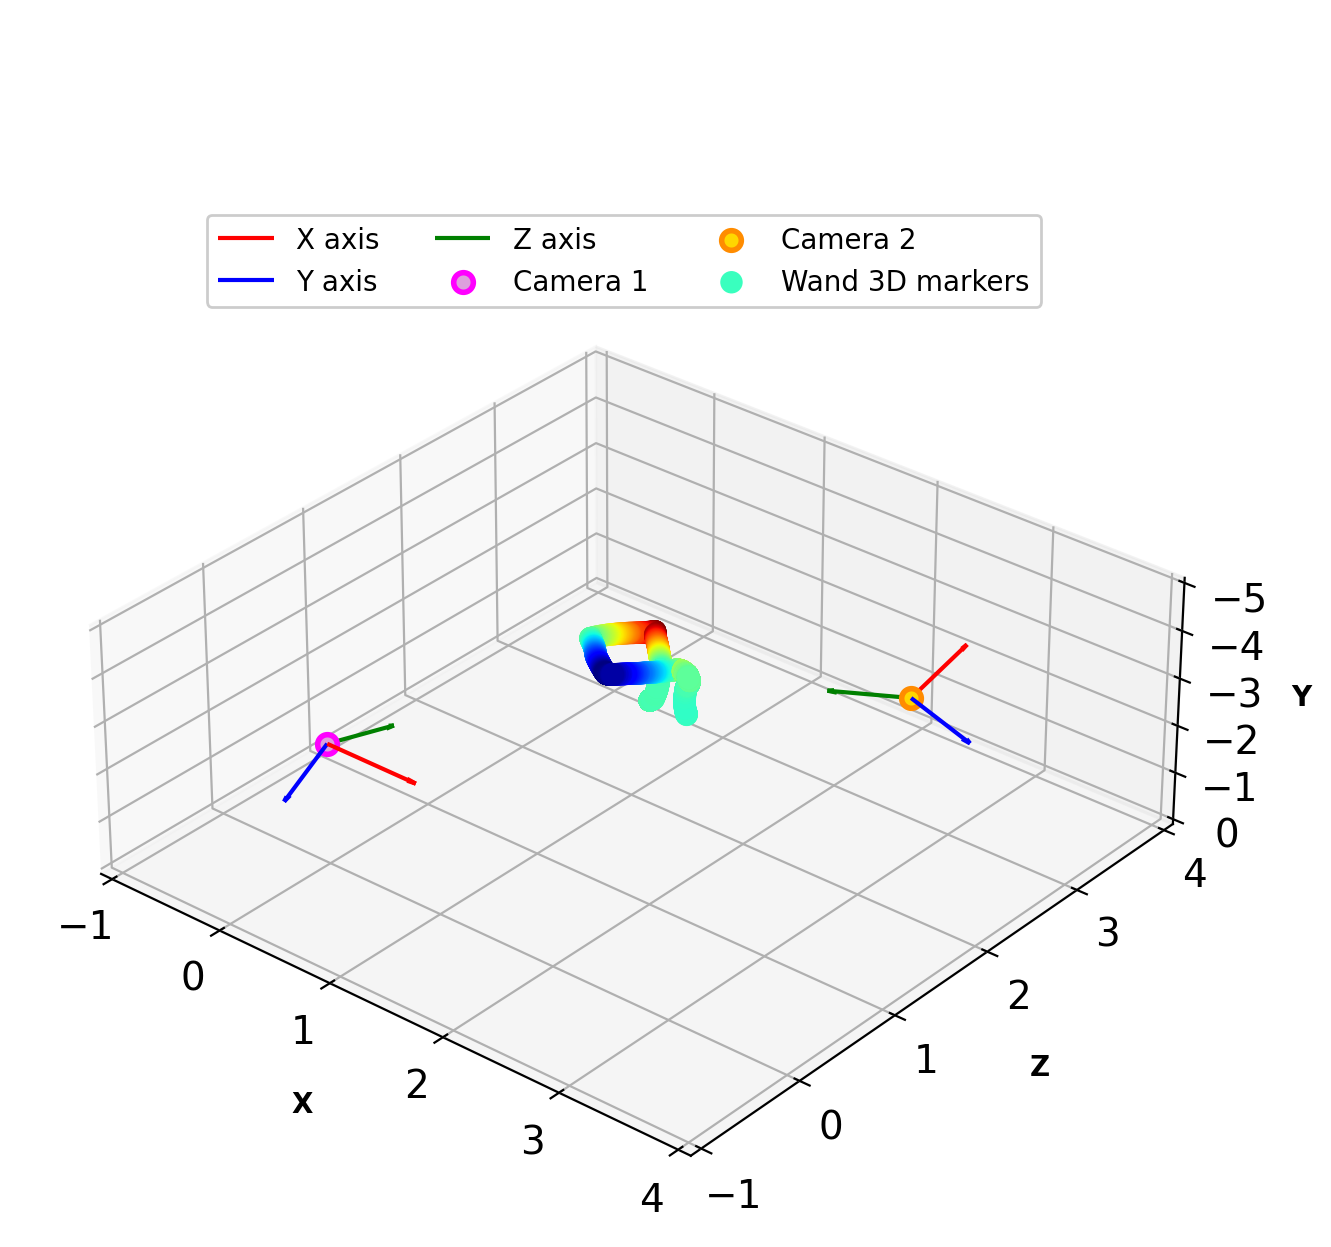

In [24]:
#projPt1,projPt2 = myProjectionPoints(np.array(centroids1)),myProjectionPoints(np.array(centroids2))
#points4d = triangulatePoints(P1.astype(float),P2.astype(float),projPt1.astype(float),projPt2.astype(float))
#points3d = (points4d[:3, :]/points4d[3, :]).T
#if points3d[0, 2] < 0: points3d = -points3d
idx = np.array(range(3,points3d.shape[0],4)).astype(int)
points3dNew = points3d[idx]*lamb/100
fig = plt.figure(figsize=(8, 8),dpi=200)
ax = plt.axes(projection='3d')
ax.set_xlim(-1, 4)
ax.set_zlim(-5, 0)
ax.set_ylim(-1, 4)
ax.set_xlabel('X', fontweight='bold',labelpad=15)
ax.set_ylabel('Z', fontweight='bold',labelpad=15)
ax.set_zlabel('Y', fontweight='bold',labelpad=5)
# plot first camera
scale = 0.8
cam1Pts = np.array([[0,d/b,0],
                    [scale, 0, 0],
                    [0, scale, 0],
                    [0, 0, scale]])
cam1PtsNew = np.matmul(R_plane,cam1Pts.T).T
[cam1Root,x,y,z]=cam1PtsNew
zDisplacement = cam1PtsNew[0,2]
cam1Root+=[0,0,-zDisplacement]
x,y,z=x/np.linalg.norm(x)*scale,y/np.linalg.norm(y)*scale,z/np.linalg.norm(z)*scale
ax.quiver(cam1Root[0],cam1Root[2],cam1Root[1],x[0],x[2],x[1], arrow_length_ratio=0.1, edgecolors="r", label = 'X axis')
ax.quiver(cam1Root[0],cam1Root[2],cam1Root[1],y[0],y[2],y[1], arrow_length_ratio=0.1, edgecolors="b", label = 'Y axis')
ax.quiver(cam1Root[0],cam1Root[2],cam1Root[1],z[0],z[2],z[1], arrow_length_ratio=0.1, edgecolors="g", label = 'Z axis')
ax.scatter(cam1Root[0],cam1Root[2],cam1Root[1], s=50, edgecolor="fuchsia", facecolor="plum", linewidth=2, label = 'Camera 1')
# plot second camera
x,y,z = np.array([scale, 0, 0]), np.array([0, scale, 0]),np.array([0, 0, scale])
x,y,z = np.matmul(R.T, x),np.matmul(R.T, y),np.matmul(R.T, z)
t_aux = np.matmul(-t, R)[0]*lamb/100+[0,d/b,0]
cam2Pts = np.array([t_aux.T,x,y,z])
cam2PtsNew = np.matmul(R_plane,cam2Pts.T).T
[cam2Root,x,y,z]=cam2PtsNew
cam2Root+=[0,0,-zDisplacement]
x,y,z=x/np.linalg.norm(x)*scale,y/np.linalg.norm(y)*scale,z/np.linalg.norm(z)*scale
ax.quiver(cam2Root[0],cam2Root[2],cam2Root[1],x[0],x[2],x[1], arrow_length_ratio=0.1, edgecolors="r")
ax.quiver(cam2Root[0],cam2Root[2],cam2Root[1],y[0],y[2],y[1], arrow_length_ratio=0.1, edgecolors="b")
ax.quiver(cam2Root[0],cam2Root[2],cam2Root[1],z[0],z[2],z[1], arrow_length_ratio=0.1, edgecolors="g")
ax.scatter(cam2Root[0],cam2Root[2],cam2Root[1], s=50, edgecolor="darkorange", facecolor="gold", linewidth=2,  label = 'Camera 2')
# new plane
points3dNew = np.matmul(R_plane,points3dNew.T+np.array([[0],[d/b],[0]])).T
ax.scatter(points3dNew[:, 0], points3dNew[:, 2]-zDisplacement, points3dNew[:, 1], c=points3dNew[:, 2], cmap=cmhot,s = 50,label='Wand 3D markers')
# axis setup
cmhot = plt.get_cmap("jet")
ax.view_init(elev=30, azim=-50) 
plt.legend(ncol=3,loc ='center',edgecolor='silver', bbox_to_anchor=(0.5, 0.8)) 
plt.gca().invert_zaxis()
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 1., .5, 1.]))
plt.draw()
plt.show()

In [25]:
#points3d_A = np.savetxt('points3d_A.csv',points3d[np.array(range(0,points3d.shape[0],4)).astype(int)]*lamb/100,delimiter=',')
#points3d_B = np.savetxt('points3d_B.csv',points3d[np.array(range(1,points3d.shape[0],4)).astype(int)]*lamb/100,delimiter=',')
#points3d_C = np.savetxt('points3d_C.csv',points3d[np.array(range(2,points3d.shape[0],4)).astype(int)]*lamb/100,delimiter=',')
#points3d_D = np.savetxt('points3d_D.csv',points3d[np.array(range(3,points3d.shape[0],4)).astype(int)]*lamb/100,delimiter=',')

In [26]:
for k in range(0,4):
    idx = np.array(range(k,points3d.shape[0],4)).astype(int)
    points3dNew = points3d[idx]*lamb/100
    points3dNew = np.matmul(R_plane,points3dNew.T+np.array([[0],[d/b],[0]])).T
    print('marker',k,'max',-min(points3dNew[:,1]),'m,','min',-max(points3dNew[:,1]),'m')
    
    #np.savetxt('points3d'+str(k)+'.csv',points3dNew,delimiter=',')

marker 0 max 0.8793837733352308 m, min 0.03548814851146753 m
marker 1 max 0.8773131684627886 m, min 0.032580008324652354 m
marker 2 max 0.8752288989353987 m, min 0.03203177230235088 m
marker 3 max 0.8910159548308347 m, min 0.049017883097879356 m


In [27]:
[A,B,C,D] = points3d[-4:]*lamb
print('0-1 >> ??.?cm >> '+str(np.linalg.norm(A-B)))
print('0-2 >> 11.5cm >> '+str(np.linalg.norm(A-C)))
print('0-3 >> 17.0cm >> '+str(np.linalg.norm(A-D)))
print('1-2 >> 10.5cm >> '+str(np.linalg.norm(B-C)))
print('1-3 >> 21.5cm >> '+str(np.linalg.norm(B-D)))
print('2-3 >> 11.0cm >> '+str(np.linalg.norm(D-C)))

0-1 >> ??.?cm >> 13.387984025165565
0-2 >> 11.5cm >> 11.319955146713502
0-3 >> 17.0cm >> 16.724742290372564
1-2 >> 10.5cm >> 10.495242517083858
1-3 >> 21.5cm >> 21.250840386547534
2-3 >> 11.0cm >> 10.849683985174453


In [28]:
'''np.savetxt('R.csv',R,delimiter=',')
np.savetxt('t.csv',t,delimiter=',')
np.savetxt('lamb.csv',np.array([lamb]),delimiter=',')
np.savetxt('F.csv',F,delimiter=',')
np.savetxt('R_plane.csv',R_plane,delimiter=',')
np.savetxt('t_plane.csv',np.array([d/b]),delimiter=',')'''


"np.savetxt('R.csv',R,delimiter=',')\nnp.savetxt('t.csv',t,delimiter=',')\nnp.savetxt('lamb.csv',np.array([lamb]),delimiter=',')\nnp.savetxt('F.csv',F,delimiter=',')\nnp.savetxt('R_plane.csv',R_plane,delimiter=',')\nnp.savetxt('t_plane.csv',np.array([d/b]),delimiter=',')"

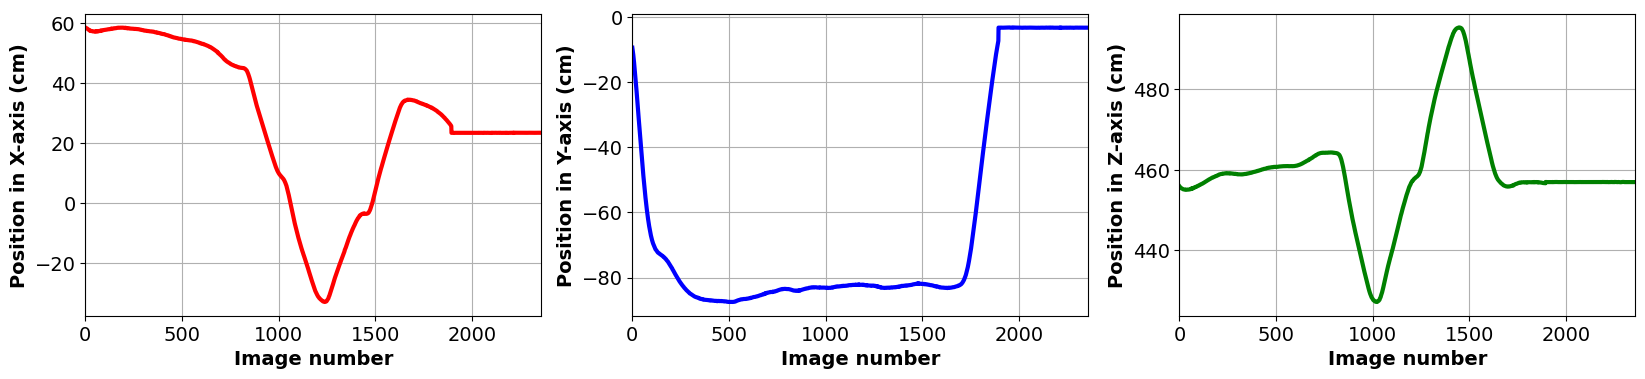

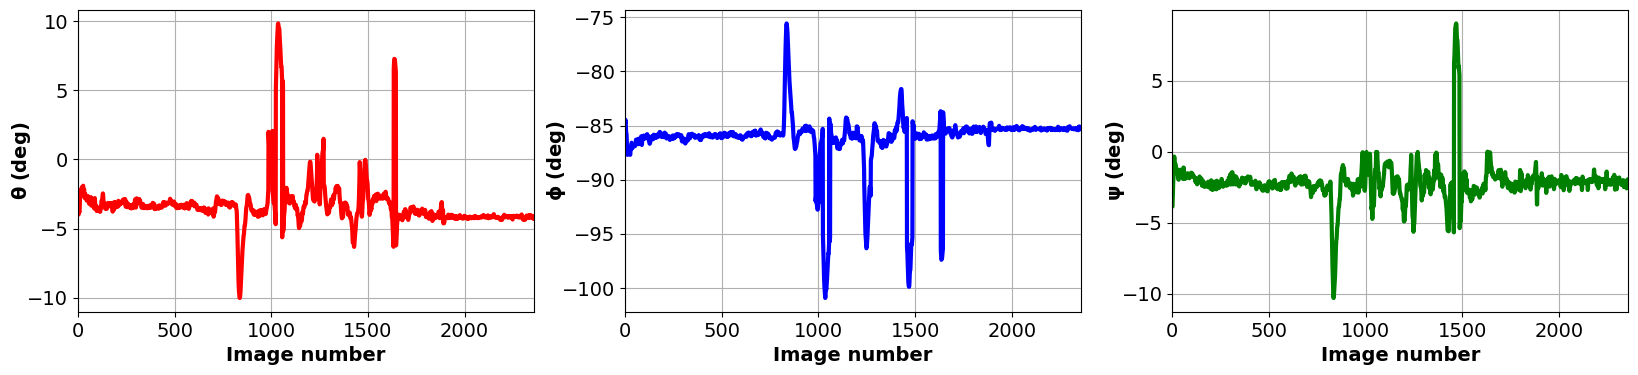

In [29]:
def getAngle(a,b):
    cosPhi = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    phi = np.arccos(cosPhi)
    return np.arctan2(np.sin(phi),cosPhi)


points3dNew = points3d*lamb/100
points3dNew = np.matmul(R_plane,points3dNew.T+np.array([[0],[d/b],[0]])).T
allCombinationsOf2 = np.array(list(combinations(list(range(0,4)),2)))
points3d_rightTriangle = []
points3d_centreOfMass = []
for k in range(0,int(points3dNew.shape[0]/4)):
    pts,myIdx = points3dNew[k*4:k*4+4],[]
    for idx in allCombinationsOf2:
        if np.linalg.norm(np.diff(pts[idx],axis=0)) > 0.15:
            myIdx.append(idx)
    myIdx = np.unique(myIdx)
    centreOfMass = [i for i in range(0,4) if i not in myIdx]
    if not len(points3d_rightTriangle): 
        points3d_centreOfMass = pts[centreOfMass]
        points3d_rightTriangle = pts[myIdx]
    else: 
        points3d_centreOfMass = np.vstack((points3d_centreOfMass,pts[centreOfMass]))
        points3d_rightTriangle = np.vstack((points3d_rightTriangle,pts[myIdx]))
# position of centre of mass
fig, axs = plt.subplots(1,3,figsize=(20,4),dpi=100)
colour = ['r','b','g']
label = ['Position in X-axis (cm)','Position in Y-axis (cm)','Position in Z-axis (cm)']
for k in range(0,3):
    axs[k].plot(points3d_centreOfMass[:,k]*100,c=colour[k],linewidth=3)
    axs[k].set_xlim((0,int(points3dNew.shape[0]/4)))
    axs[k].grid(True)
    axs[k].set_ylabel(label[k],fontweight='bold',size=14)
    axs[k].set_xlabel('Image number',fontweight='bold',size=14)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
# get orientation
myOrientation = []
for k in range(0,int(points3d_rightTriangle.shape[0]/3)):
    pts = points3d_rightTriangle[k*3:k*3+3]
    plane = findPlane(pts[0],pts[1],pts[2])
    if np.any(plane[0:3]<0): plane = findPlane(pts[0],pts[2],pts[1])
    theta = np.rad2deg(getAngle(plane[0:3],[1,0,0]))-90
    phi = np.rad2deg(getAngle(plane[0:3],[0,1,0]))-90
    if phi > 0: phi-=180
    psi = np.rad2deg(getAngle(plane[0:3],[0,0,1]))-90
    if not len(myOrientation): myOrientation = [theta,phi,psi]
    else: myOrientation = np.vstack((myOrientation,[theta,phi,psi]))
fig, axs = plt.subplots(1,3,figsize=(20,4),dpi=100)
colour = ['r','b','g']
label = [r'$\mathbf{\theta\;(deg)}$',r'$\mathbf{\phi\;(deg)}$',r'$\mathbf{\psi\;(deg)}$']
for k in range(0,3):
    axs[k].plot((myOrientation[:,k]),c=colour[k],linewidth=3)
    axs[k].set_xlim((0,int(points3dNew.shape[0]/4)))
    axs[k].grid(True)
    axs[k].set_ylabel(label[k],size=14,labelpad=-4)
    axs[k].set_xlabel('Image number',fontweight='bold',size=14)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
